# MBA em Ciência de Dados
## Técnicas Avançadas de Captura e Tratamento de Dados


### <span style="color:darkred">Módulo VII - Dados não estruturados: sinais e imagens</span>

Material Produzido por Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-05-21 10:42:07.216518: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-21 10:42:07.216546: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


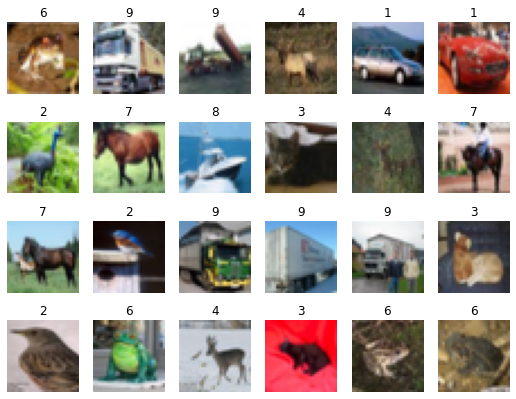

In [42]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

fig, axes = plt.subplots(4,6, figsize=(9,7))
ax = axes.ravel()
for i in range(24):
    ax[i].imshow(x_train[i], cmap="gray")
    ax[i].set_title("%d" % (y_train[i]))
    ax[i].axis('off')

In [3]:
### comparar imagens
def dist_Euclid(a,b):
    return  np.sqrt(np.sum(np.power(a-b, 2)))

In [6]:
# CBIR

# imagem consulta
q = 0 # q é o índice da imagem de consulta (query)

min_d = 0  # menor distancia encontrada
min_i = 0  # indice relativo a menor distancia

# for
for i in range(1000):
    dis = dist_Euclid(x_train[i], x_train[q])
    if i != q and (min_d == 0 or dis < min_d):
        min_d = dis
        min_i = i


572.1914015432249


In [11]:
# CBIR

# imagem consulta
q = 200 # q é o índice da imagem de consulta (query)

min_d = 0  # menor distancia encontrada
min_i = 0  # indice relativo a menor distancia

# comprehension
v_dist = [dist_Euclid(x_train[i], x_train[q]) for i in range(1000)]
v_dist[q] = np.max(v_dist)
min_d = np.min(v_dist)
min_i = np.argmin(v_dist)

Text(0.5, 1.0, 'Recuperada')

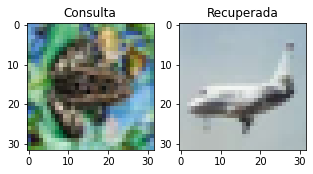

In [12]:
fig = plt.figure(figsize=(5,3))
plt.subplot(121); plt.imshow(x_train[q]); plt.title('Consulta')
plt.subplot(122); plt.imshow(x_train[min_i]); plt.title('Recuperada')

In [14]:
np.prod(x_train[0].shape)

3072

#### Extração de características via rede neural convolucional

In [15]:
# carregando pessos pré-treinados de uma rede neural
base_model_extraction = keras.applications.MobileNetV2(
    weights="imagenet",
    input_shape=(32, 32, 3),
    include_top=False
)

# obtemos a camada de saída do modelo carregado (última camada pois não incluímos o topo da rede)
base_output = base_model_extraction.layers[-1].output

# para evitar uma dimensionalidade alta, definimos uma nova camada de saída
feat_layer = keras.layers.GlobalAveragePooling2D()(base_output)

# montamos um novo modelo com a entrada do pré-treinado, e saída criada acima
model_imagenet = keras.models.Model(base_model_extraction.inputs, feat_layer)

2022-05-21 10:55:33.741117: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-21 10:55:33.741186: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-21 10:55:33.741246: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-21 10:55:33.741641: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [38]:
## extrair características e comparar

feats_net = np.array(model_imagenet.predict(x_train[:1000]))
feats_net_test = np.array(model_imagenet.predict(x_test[:1000]))
print('Dados x features obtidas', feats_net.shape)
print('Dados x features obtidas teste', feats_net_test.shape)

Dados x features obtidas (1000, 1280)
Dados x features obtidas teste (1000, 1280)


In [50]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
feats_pca = pca.fit_transform(feats_net)
feats_pca_test = pca.transform(feats_net_test)
print('Dados x features obtidas pca', feats_pca.shape)
print('Dados x features obtidas pca test', feats_pca_test.shape)

Dados x features obtidas pca (1000, 100)
Dados x features obtidas pca test (1000, 100)


In [51]:
# CBIR

# imagem consulta
q = 100 # q é o índice da imagem de consulta (query)

min_d = 0  # menor distancia encontrada
min_i = 0  # indice relativo a menor distancia

# comprehension
v_dist = [dist_Euclid(feats_pca[i], feats_pca[q]) for i in range(1000)]
v_dist[q] = np.max(v_dist)
min_d = np.min(v_dist)
min_i = np.argmin(v_dist)

Text(0.5, 1.0, 'Recuperada [8]')

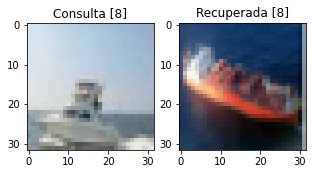

In [52]:
fig = plt.figure(figsize=(5,3))
plt.subplot(121); plt.imshow(x_train[q]); plt.title('Consulta '+str(y_train[q]))
plt.subplot(122); plt.imshow(x_train[min_i]); plt.title('Recuperada '+str(y_train[min_i]))

In [53]:
## treinar classificador SVM
from sklearn.svm import SVC
clf = SVC()
clf.fit(feats_pca, y_train[:1000])

y_pred = clf.predict([feats_pca_test[0]])

/home/maponti/.virtualenvs/rn22/lib/python3.10/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [54]:
print(y_test[0])
print(y_pred)

[3]
[2]


In [55]:
y_pred = clf.predict(feats_pca_test[:10])

In [56]:
print(y_test[:10].reshape(1,-1))
print(y_pred)

[[3 8 8 0 6 6 1 6 3 1]]
[2 2 1 1 2 6 7 2 2 1]
